# Identifying Parkinson's Disease Using Machine Learning Methods


Start by installing necessary packages to process, normalize, and build our model

In [51]:
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

The data I received is from UC Irvine and contains 23 features(columns) with 195 records(rows)

In [2]:
data =pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data')
data.shape

(195, 24)

In [3]:
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


I separate the data into numpy arrays of features and labels <br>
The features are defined as all the columns that are not the status <br>
The 'status' column indicates whether that patient has Parkinson's ( indicated by 1 in row ) or does not have( indicated by 0 in row ) <br>

In [4]:
features = data.loc[:,data.columns!='status'].values[:,1:]
labels = data.loc[:,'status'].values

Now I look at the distribution of labelled Parkinson's vs Does Not Have Parkinson's

In [5]:
poslabels = labels[labels == 1 ].shape[0]
neglabels = labels[labels == 0 ].shape[0]

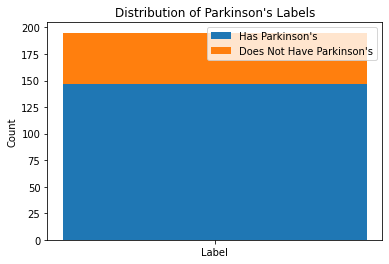

In [6]:
fig, ax = plt.subplots()
width = 0.25
ax.bar('Label', poslabels, width, label="Has Parkinson's")
ax.bar('Label', neglabels, width, bottom=poslabels, label="Does Not Have Parkinson's")
ax.set_ylabel('Count')
ax.set_title("Distribution of Parkinson's Labels")
ax.legend()
plt.show()


Now we understand the distribution of positive and negative labels lets look at each of our features to see if multicollinearity exists 

First I do some data preprocessing

In [7]:
x_train,x_test,y_train,y_test=train_test_split(features, labels, test_size=0.2, random_state=9)

Usually I splitting again so we have a validation set and a leave out test set to avoid data leak and overfitting to the test set <br>
However in this case because I am doing Cross validation wihtin grid search for my parameters this is not required

create train set then validation set then test set at the end<br>
we do validation set by running the code against on the xtrain y train

In [8]:
pca = PCA(n_components= x_train.shape[1])
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


Here are the eigen values

In [9]:
pca.explained_variance_ratio_

array([7.28046875e-01, 2.21177040e-01, 4.93676979e-02, 1.36326579e-03,
       3.70332131e-05, 6.30031869e-06, 9.15578338e-07, 4.44383759e-07,
       2.49044343e-07, 1.07925009e-07, 3.74024914e-08, 2.63402931e-08,
       5.50224189e-09, 9.04202121e-10, 5.24134722e-10, 2.41541325e-10,
       2.84935842e-11, 1.80487029e-11, 4.43422384e-12, 2.22061392e-15,
       5.36240931e-16, 4.19918228e-16])

In [70]:
percentageofvariance = pca.explained_variance_ratio_[0] +pca.explained_variance_ratio_[1] +pca.explained_variance_ratio_[2]
percentageofvariance

0.9985916127828117

the first 3 components seem to explain the majority of the data. 18 of the remaining features appear to be collinear with each other and do not explain the variance of the data well <br>

<AxesSubplot:xlabel='PC', ylabel='Variance'>

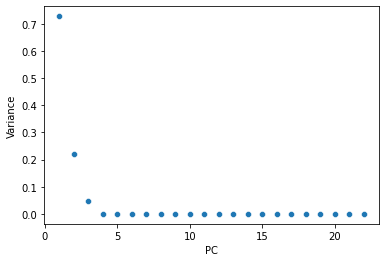

In [10]:
pcaexplained = pd.DataFrame({'PC':np.arange(pca.n_components)+1, 'Variance': pca.explained_variance_ratio_})
sns.scatterplot(data=pcaexplained, x = 'PC', y = 'Variance')


In [11]:
x_train_pcadf = pd.DataFrame(x_train_pca)
x_test_pcadf = pd.DataFrame(x_test_pca)
pcadf = pd.concat([x_train_pcadf, x_test_pcadf])
pcadf['Label'] = ['Train']*x_train_pcadf.shape[0]+['Test']*x_test_pcadf.shape[0]


The first 3 components look to express train,validation, and test sets well<br>

I do this as a sanity check to make sure that the model trained on the train set would generalize well to the test set

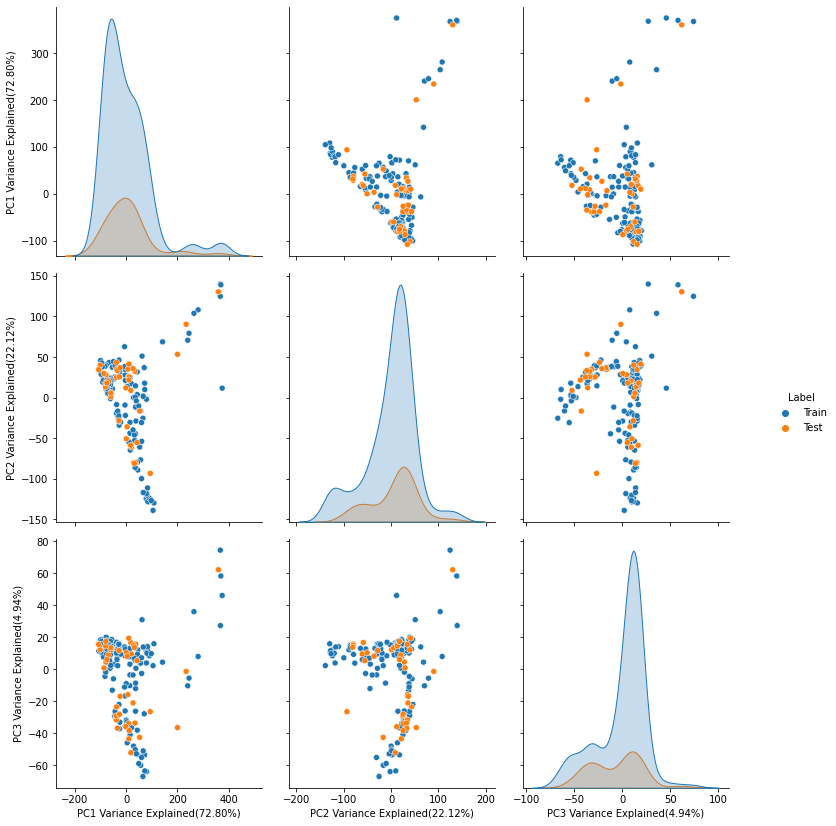

In [12]:
g= sns.pairplot(pcadf.loc[:,[0, 1, 2, 'Label']],hue = 'Label')
g.fig.set_size_inches(12,12)
replacements = {
    '0': "PC1 Variance Explained({:.2f}%)".format(pca.explained_variance_ratio_[0]*100),
    '1': "PC2 Variance Explained({:.2f}%)".format(pca.explained_variance_ratio_[1]*100),
    '2': "PC3 Variance Explained({:.2f}%)".format(pca.explained_variance_ratio_[2]*100)}

for i in range(3):
    for j in range(3):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

In [13]:
plot = pd.DataFrame(x_train_pca)
plot['reallabel'] = y_train

A linear classifier like logistic regression will probably not perform that well because there is not a linear distincition between 0 and 1 that can robustly separate the two classes <br>
0 indicates No Parkinson's Present <br>
1 indicates Parkinson's Present

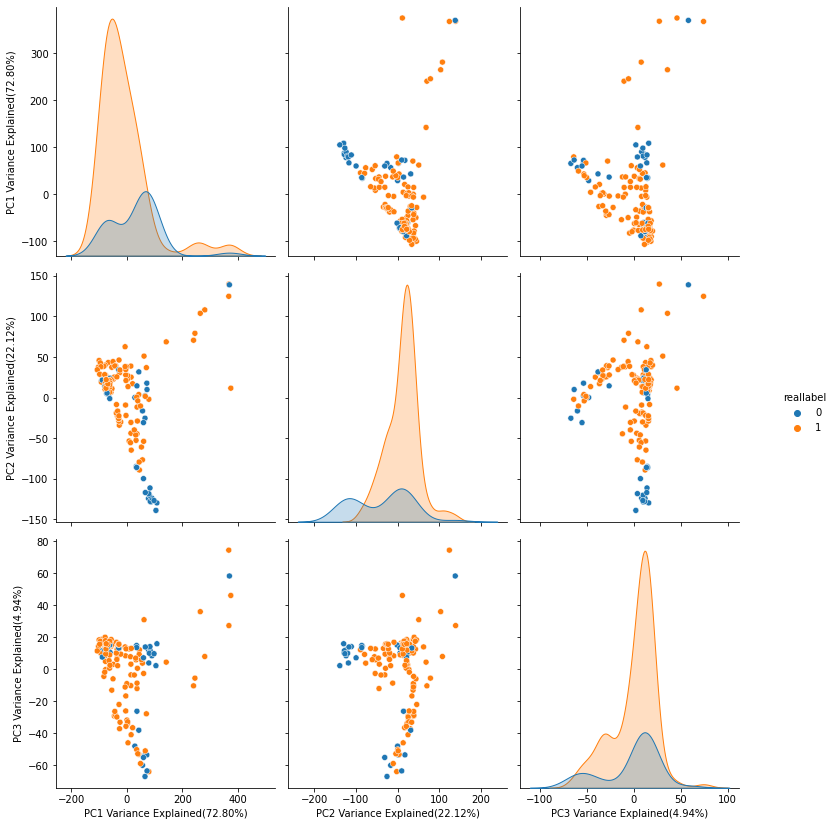

In [14]:
b = sns.pairplot(data=plot.loc[:,[0, 1, 2, 'reallabel']], hue='reallabel')

b.fig.set_size_inches(12,12)

replacements = {
    '0': "PC1 Variance Explained({:.2f}%)".format(pca.explained_variance_ratio_[0]*100),
    '1': "PC2 Variance Explained({:.2f}%)".format(pca.explained_variance_ratio_[1]*100),
    '2': "PC3 Variance Explained({:.2f}%)".format(pca.explained_variance_ratio_[2]*100)}

for i in range(3):
    for j in range(3):
        xlabel = b.axes[i][j].get_xlabel()
        ylabel = b.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            b.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            b.axes[i][j].set_ylabel(replacements[ylabel])


In [15]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = plot['reallabel'])
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()



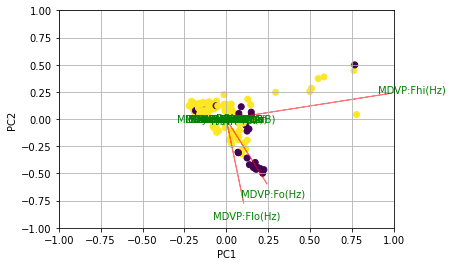

In [16]:
#Call the function. Use only the 2 PCs.
myplot(x_train_pca[:,0:2],np.transpose(pca.components_[0:2, :]), data.columns[1:])
plt.show()

Here I checked the correlation coefficient between the different projected features<br>

I verified that the MDVP:Flo(Hz) and MDVP:Fo(Hz) would have the highest correlation because they have the smallest degree of separation <br>
I verified that the MDVP:Fhi(Hz) and MDVP:Fo(Hz) would have an intermediate correlation because it has the second largest degree of separation <br>
I verified that the MDVP:Flo(Hz) and MDVP:Fhi(Hz) would have little to no correlation because it is almost perpendicular and has largest degree of separation <br>

In [17]:
data['MDVP:Fo(Hz)'].corr(data['MDVP:Flo(Hz)'])

0.5965455187557578

In [18]:
data['MDVP:Fhi(Hz)'].corr(data['MDVP:Fo(Hz)'])

0.40098467624606277

In [19]:
data['MDVP:Fhi(Hz)'].corr(data['MDVP:Flo(Hz)'])

0.08495125082573741

This plot depicts the two classes of 0 and 1 against the first component on the y axis <br>
It can be seen that there is a difference in populations

<AxesSubplot:xlabel='reallabel', ylabel='0'>

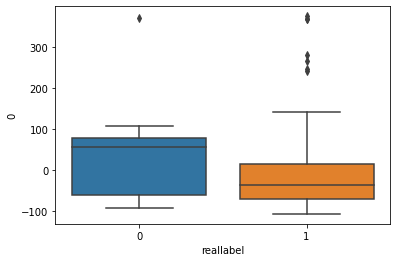

In [20]:
sns.boxplot(data=plot, x = 'reallabel', y = 0 )

I first train a model on shuffled labelled train set <br>
This is essentially a unit test as I am setting an accuracy baseline for what a "junk" data + model set

In [21]:
steps = [("Scale", StandardScaler()), ("pca", PCA()), ("Logistic", LogisticRegression())]
pipeline = Pipeline(steps)
params = {
    "pca__n_components" : [4,14,21]
}
grid = GridSearchCV(pipeline, param_grid= params, cv = 5)
np.random.shuffle(y_train)
grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scale', StandardScaler()),
                                       ('pca', PCA()),
                                       ('Logistic', LogisticRegression())]),
             param_grid={'pca__n_components': [4, 14, 21]})

In [22]:
grid.best_estimator_

Pipeline(steps=[('Scale', StandardScaler()), ('pca', PCA(n_components=4)),
                ('Logistic', LogisticRegression())])

In [23]:
grid.best_score_

0.7629032258064516

In [24]:
x_train,x_test,y_train,y_test=train_test_split(features, labels, test_size=0.2, random_state=9)

In [25]:
steps = [("Scale", StandardScaler()), ("pca", PCA()), ("Logistic", LogisticRegression())]
pipeline = Pipeline(steps)
params = {
    "pca__n_components" : [4,14,21]
}
grid = GridSearchCV(pipeline, param_grid= params, cv = 5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scale', StandardScaler()),
                                       ('pca', PCA()),
                                       ('Logistic', LogisticRegression())]),
             param_grid={'pca__n_components': [4, 14, 21]})

In [26]:
grid.best_estimator_

Pipeline(steps=[('Scale', StandardScaler()), ('pca', PCA(n_components=4)),
                ('Logistic', LogisticRegression())])

In [27]:
grid.best_score_

0.8332661290322582

I see a slight improvement in a logistic regression with only the first 4 components after grid searching for best parameters <br>
Let us see if other non linear models will perform better

In [40]:
steps = [("Scale", StandardScaler()), ("pca", PCA()), ("XGBoost", XGBClassifier(verbosity = 0, use_label_encoder =False))]
pipeline = Pipeline(steps)
params = {
    "pca__n_components" : [4,14,21],
    'XGBoost__max_depth': [2, 3, 5, 7, 10],
    'XGBoost__learning_rate': [0.1, 0.01, 0.05]

}
grid = GridSearchCV(pipeline, param_grid= params, cv = 5)
np.random.shuffle(y_train)
grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scale', StandardScaler()),
                                       ('pca', PCA()),
                                       ('XGBoost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                           

In [41]:
grid.best_estimator_

Pipeline(steps=[('Scale', StandardScaler()), ('pca', PCA(n_components=4)),
                ('XGBoost',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               va

In [42]:
grid.best_score_

0.7629032258064516

In [47]:
x_train,x_test,y_train,y_test=train_test_split(features, labels, test_size=0.2, random_state=9)

In [48]:
steps = [("Scale", StandardScaler()), ("pca", PCA()), ("XGBoost", XGBClassifier(verbosity = 0, use_label_encoder =False))]
pipeline = Pipeline(steps)
params = {
    "pca__n_components" : [4,14,21],
    'XGBoost__max_depth': [2, 3, 5, 7, 10],
    'XGBoost__learning_rate': [0.1, 0.01, 0.05]

}
grid = GridSearchCV(pipeline, param_grid= params, cv = 5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scale', StandardScaler()),
                                       ('pca', PCA()),
                                       ('XGBoost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                           

In [49]:
grid.best_estimator_

Pipeline(steps=[('Scale', StandardScaler()), ('pca', PCA(n_components=14)),
                ('XGBoost',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               va

In [50]:
grid.best_score_

0.8846774193548388

We can clearly see a strong improvement in prediction accuracy when using XGboost from ~75% to close to ~90& accuracy, and xgboost will help with the class imbalance we have

In [60]:
x_train,x_test,y_train,y_test=train_test_split(features, labels, test_size=0.2, random_state=9)

In [62]:
steps = [("Scale", StandardScaler()), ("pca", PCA()), ("rf", RandomForestClassifier())]
pipeline = Pipeline(steps)
params = {
    "pca__n_components" : [4,14,21],
    'rf__max_depth': [2, 3, 5, 7, 10]

}
grid = GridSearchCV(pipeline, param_grid= params, cv = 5)
np.random.shuffle(y_train)
grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scale', StandardScaler()),
                                       ('pca', PCA()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'pca__n_components': [4, 14, 21],
                         'rf__max_depth': [2, 3, 5, 7, 10]})

In [63]:
grid.best_estimator_

Pipeline(steps=[('Scale', StandardScaler()), ('pca', PCA(n_components=4)),
                ('rf', RandomForestClassifier(max_depth=10))])

In [64]:
grid.best_score_

0.7691532258064516

In [65]:
x_train,x_test,y_train,y_test=train_test_split(features, labels, test_size=0.2, random_state=9)

In [66]:
steps = [("Scale", StandardScaler()), ("pca", PCA()), ("rf", RandomForestClassifier())]
pipeline = Pipeline(steps)
params = {
    "pca__n_components" : [4,14,21],
    'rf__max_depth': [2, 3, 5, 7, 10]

}
grid = GridSearchCV(pipeline, param_grid= params, cv = 5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scale', StandardScaler()),
                                       ('pca', PCA()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'pca__n_components': [4, 14, 21],
                         'rf__max_depth': [2, 3, 5, 7, 10]})

In [67]:
grid.best_estimator_

Pipeline(steps=[('Scale', StandardScaler()), ('pca', PCA(n_components=21)),
                ('rf', RandomForestClassifier(max_depth=5))])

In [68]:
grid.best_score_

0.9036290322580646

I again see a strong improvement in accuracy comparing our "junk" model compared to our "real" model

### Discussion

Our results indicate that RF and XGBoosting performed the best in classifying Parkinson's with both accuracies around 90% compared to the ~70% class imbalance in the data we recieve. With gridsearch we are able to select tuned hyperparameters while using Cross Validation to adjust for overfitting to the test set. If I had to choose one model to go implement I would use the XGboost as it is the better option for unbalanced datasets as we see here and often in reality. XGBoost provides a preference to finding the underrepresented class and has a correction criteria. The linear model (logistic regression) performed poorly as expected due to the non-linear relationships. A very interesting facet of the PCA analysis was that although the first 3 components accounted for 99% of the explained variance of the data, the remaining components had a large effect in increasing the accuracy as the RF and XGboost returned the highest accuracies with 14 and 21 components rather than the first 3 which we would expect. Some of those features one would think are irrelavent are indeed important in distinguishing Parkinson's, further in depth analysis would be required to determine the exact cause of this. Future works on this project could include plotting of confusions matrixes as well as ROC Curves. 